In [1]:
import os

# set CUDA_VISIBLE_DEVICES
home_dir = "/mnt/home/gviveiros/LLaVA-NeXT/"
os.chdir(home_dir)
#cuda_allocated_device_id = 0
#os.environ["CUDA_VISIBLE_DEVICES"] = str(cuda_allocated_device_id)
#!nvidia-smi --id $cuda_allocated_device_id 
!nvidia-smi
!pwd


Fri Aug 22 16:54:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:4F:00.0 Off |                  Off |
| 30%   28C    P8             27W /  300W |   44157MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **LLaVA-NeXT** Native

In [2]:
# Cell 1: Imports
import torch
from PIL import Image
import copy
from pathlib import Path

# Import LLaVA components
from llava.constants import DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
from llava.conversation import conv_templates
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.model.builder import load_pretrained_model

/mnt/home/gviveiros/.conda/envs/llava-next-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Cell 2: Function to load the model
def load_model(model_path, token=None, device="cuda"):
    """
    Load the LLaVA model, tokenizer, and image processor
    
    Args:
        model_path: HuggingFace model path or local path
    
    Returns:
        tokenizer, model, image_processor, device
    """
    # Set device
    #device = "cuda"
    if device == "cuda":
        device_map = f"{device}:0"
    else:
        device_map = "cpu"
    #device_map = f"{device}:0"
    
    # Load model
    model_name = get_model_name_from_path(model_path)
    print("Model name: ", model_name)
    llava_args = {
        "multimodal": True,
        "attn_implementation": "sdpa" if torch.version.cuda and torch.__version__ >= "2.1.2" else "eager"
    }
    
    print("Loading model... model_path: ", model_path, "model_name: ", model_name)
    tokenizer, model, image_processor, max_length = load_pretrained_model(
        model_path, None, model_name, torch_dtype="bfloat16", device_map=device_map, **llava_args
    )
    model.eval()
    
    return tokenizer, model, image_processor, device

In [4]:
# Cell 3: Load the model (run this once)
#model_path = "Unbabel/lnext-towerqmix-7b-dpo-siglip2-v6"
#model_path = "Unbabel/lnext-eurollm_1p7b_30k-siglip2-v6-step6640"
model_path = "/mnt/scratch-artemis/gviveiros/TowerVision/llava-next-native/towerp_2b_base/"
tokenizer, model, image_processor, device = load_model(model_path, device="cpu")
print(f"Model loaded on {device}")

Model name:  towerp_2b_base
Loading model... model_path:  /mnt/scratch-artemis/gviveiros/TowerVision/llava-next-native/towerp_2b_base/ model_name:  towerp_2b_base
Loading LLaVA model from -> /mnt/scratch-artemis/gviveiros/TowerVision/llava-next-native/towerp_2b_base/
Using LLavaGemma2 class
Loading vision tower: /mnt/scratch-artemis/gviveiros/siglip2-so400m-patch14-384/


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Model Class: LlavaGemma2ForCausalLM
Model loaded on cpu


In [9]:
# Cell 4: Define the inference function
def run_inference(
    image, 
    prompt,
    tokenizer=tokenizer,
    model=model,
    image_processor=image_processor,
    device=device,
    conv_template="gemma2_instruct",
    max_new_tokens=512,
    temperature=0.,
    log_prompt=False
):
    """
    Run inference with a pre-loaded LLaVA model
    
    Args:
        image_path: Path to the image file
        prompt: Text prompt to send to the model
        tokenizer, model, image_processor: Pre-loaded model components
        device: The device to run inference on
        conv_template: Conversation template to use
        max_new_tokens: Maximum number of tokens to generate
        temperature: Sampling temperature (0 for deterministic)
    
    Returns:
        The model's response
    """
    # Load and process image
    #image = Image.open(image_path).convert('RGB')
    image_size = [image.size[0], image.size[1]]

    # DEBUG: dump image file pixel values (before any processing)
    import numpy as np
    image_pixels = np.array(image)
    torch.save(image_pixels, "image_pixels.pt")

    processed_image = process_images([image], image_processor, model.config)

    #if torch.cuda.is_available():
    processed_image = processed_image.to(dtype=torch.bfloat16, device=device)
    
    # Prepare conversation
    if DEFAULT_IMAGE_TOKEN not in prompt:
       print(f"Adding {DEFAULT_IMAGE_TOKEN} to prompt")
       prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt
    
    # This is safer for llama3 models
    if "llama_3" in conv_template:
        conv = copy.deepcopy(conv_templates[conv_template])
    else:
        conv = conv_templates[conv_template].copy()
    
    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], None)
    prompt_text = conv.get_prompt()
    
    def pad_sequence(input_ids, batch_first, padding_value):
        if tokenizer.padding_side == "left":
            input_ids = [torch.flip(_input_ids, [0]) for _input_ids in input_ids]
        input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=batch_first, padding_value=padding_value)
        if tokenizer.padding_side == "left":
            input_ids = torch.flip(input_ids, [1])
        return input_ids

    if log_prompt:
        print(prompt_text)
    
    # Tokenize input
    input_ids_list = [tokenizer_image_token(prompt_text, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").to(device)]
    print(input_ids_list[0])
    
    # Generate response
    pad_token_ids = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
    input_ids = pad_sequence(input_ids_list, batch_first=True, padding_value=pad_token_ids).to(device)
    attention_masks = input_ids.ne(pad_token_ids).to(device)
    

    with torch.inference_mode():
        input_ids = input_ids.to(device)
        model = model.to(device)
        processed_image = processed_image.to(device)

        output_ids = model.generate(
            input_ids,
            attention_mask=attention_masks,
            pad_token_id=pad_token_ids,
            eos_token_id=tokenizer.eos_token_id,
            images=processed_image,
            image_sizes=[image_size],
            do_sample=temperature > 0,
            temperature=temperature,
            max_new_tokens=max_new_tokens,
            use_cache=True,
        )
    
    # Decode output
    output = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
    response = output.split(conv.roles[1] + ": ")[-1].strip()
    
    return response

In [10]:
# Define Likelihood function
def calculate_likelihood(
    image, 
    prompt,
    target,
    tokenizer=tokenizer,
    model=model,
    image_processor=image_processor,
    device=device,
    conv_template="gemma2_instruct",
    log_prompt=False
):
    """
    Calculate the likelihood of a given translation for an image-text pair
    
    Args:
        image: PIL image
        source_text: Source text to translate
        target_text: Target translation to evaluate
        tokenizer, model, image_processor: Pre-loaded model components
        device: The device to run inference on
        conv_template: Conversation template to use
    
    Returns:
        tuple: (loss value, boolean indicating if greedy prediction matches target exactly)
    """
    # Process image
    image_size = [image.size[0], image.size[1]]
    processed_image = process_images([image], image_processor, model.config)
    
    #if torch.cuda.is_available():
    processed_image = processed_image.to(dtype=torch.bfloat16, device=device)
    
    # Prepare prompt
    if DEFAULT_IMAGE_TOKEN not in prompt:
        #print(f"Adding {DEFAULT_IMAGE_TOKEN} to prompt")
        prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt
    
    # Prepare conversation
    if "llama_3" in conv_template:
        conv = copy.deepcopy(conv_templates[conv_template])
    else:
        conv = conv_templates[conv_template].copy()
    
    # First create context-only conversation (up to model's turn)
    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], None)
    context_prompt = conv.get_prompt()

    if log_prompt:
        print(context_prompt)
    
    # Tokenize context
    context_ids = tokenizer_image_token(context_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").to(device)
    
    # Now create full conversation with target answer
    conv.messages[-1][1] = target  # Set the model's response to the target text
    full_prompt = conv.get_prompt()
    if log_prompt:
        print(full_prompt)
    
    # Tokenize full prompt
    input_ids = tokenizer_image_token(full_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
    
    # Create labels with -100 for context part (we don't compute loss for it)
    labels = input_ids.clone()
    labels[0, :context_ids.shape[0]] = -100
    
    # Calculate loss
    with torch.inference_mode():
        outputs = model(
            input_ids=input_ids, 
            labels=labels, 
            images=processed_image, 
            use_cache=True, 
            image_sizes=[image_size]
        )
    
    loss = outputs["loss"]
    
    # Check if greedy prediction matches target
    logits = outputs["logits"]
    greedy_tokens = logits.argmax(dim=-1)
    # print(logits.shape)
    target_tokens = input_ids[:, context_ids.shape[0]:]  # Skip the context tokens
    greedy_tokens = greedy_tokens[:, context_ids.shape[0]:input_ids.shape[1]]  # Use only relevant predictions
    max_equal = (greedy_tokens == target_tokens).all()
    
    return float(loss.item())

### Test the model

#### One off example

In [11]:
device

'cpu'

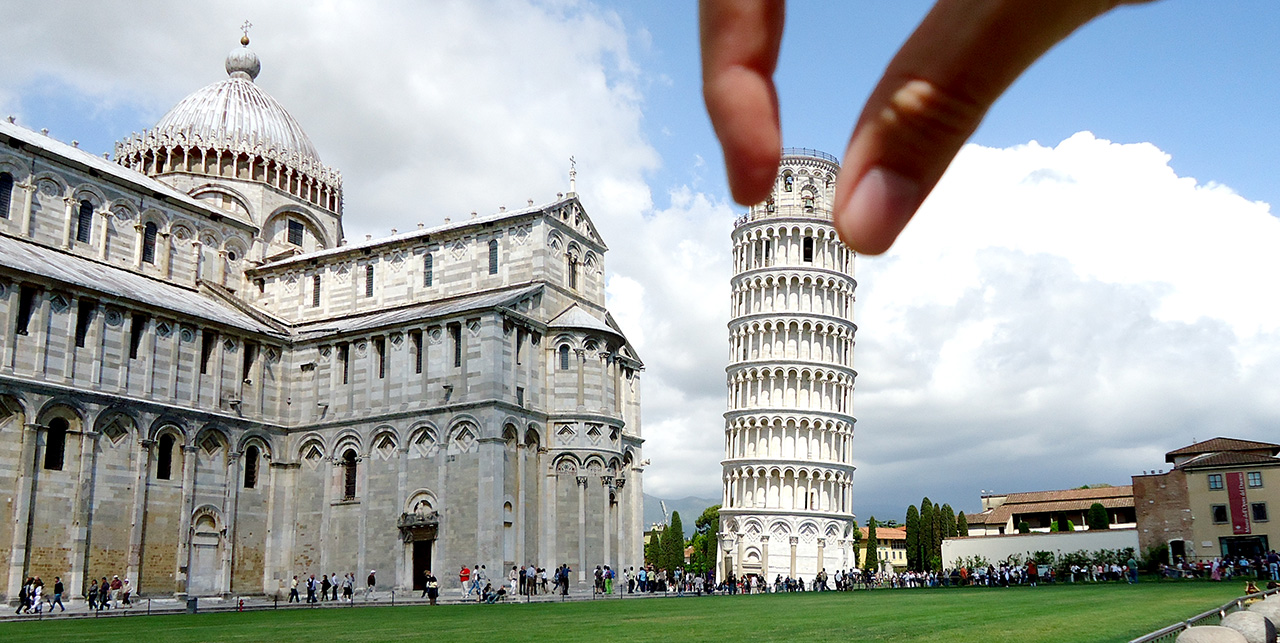

(1280, 643)
<start_of_turn>user
<image>
Is this person really big, or is this building just super small?<end_of_turn>
<start_of_turn>model

tensor([     2,    106,   1645,    108,   -200,    108,   2437,    736,   1552,
          2277,   2824, 235269,    689,    603,    736,   4547,   1317,   2557,
          2301, 235336,    107,    108,    106,   2516,    108])


/mnt/home/gviveiros/.conda/envs/llava-next-env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Model Greedy Response: This is


In [13]:
# load image from url
import requests

url = "https://cms.mistral.ai/assets/a10b924e-56b3-4359-bf6c-571107811c8f"
image = Image.open(requests.get(url, stream=True).raw)
display(image)
print(image.size)

prompt = """<image>\nIs this person really big, or is this building just super small?"""
#conversation = [
#    {
#        "role": "system",
#        "content": "Give a concise answer based on what you see in the image."
#    },
#    {
#        "role": "user",
#        "content": prompt
#    }
#]

response = run_inference(
    image, 
    prompt, 
    tokenizer, 
    model, 
    image_processor, 
    device,
    conv_template="gemma2_instruct",
    max_new_tokens=2,
    log_prompt=True
)
print(f"Model Greedy Response: {response}")


#### Dataset

In [6]:
import datasets

# load dataset
ds = datasets.load_dataset("Unbabel/commute_multimodal_mt", split="de")

/mnt/home/gviveiros/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
tokenizer.eos_token
# encode the work <|im_start|>
tokenizer.encode("<|im_start|>")
# check the token associated to img pad

[2, 235322, 235371, 571, 235298, 2997, 73786]

In [44]:
sample = ds[0]
# display(sample["image"])
prompt = f"<image>\nWhat's in this image?"
response = run_inference(sample["image"], prompt, tokenizer, model, image_processor, device, conv_template="gemma2_instruct", log_prompt=True)
print(f"Model Greedy Response: {response}")
print("-"*10)
prompt = f"<image>\nTranslate from English to Portuguese:\n{sample['source']}"
response = run_inference(sample["image"], prompt, tokenizer, model, image_processor, device, conv_template="gemma2_instruct", log_prompt=True)
print(f"Model Greedy Response: {response}")

<start_of_turn>user
<image>
What's in this image?<end_of_turn>
<start_of_turn>model

tensor([     2,    106,   1645,    108,   -200,    108,   1841, 235303, 235256,
           575,    736,   2416, 235336,    107,    108,    106,   2516,    108],
       device='cuda:0')
Model Greedy Response: The image shows a close-up view of a person's hand, specifically focusing on their palm and fingers. There's a noticeable bump or mole on the center of the palm, which appears to be the main subject of the image. The hand is positioned with the palm facing up, and the fingers are slightly curled.

The background is somewhat blurry, but you can make out a blue carpet with white and gray stripes. There's also a pair of shoes visible, which seem to be white with red accents.

The lighting in the image is somewhat dim, giving it a slightly dark atmosphere. The hand is the central focus of the image, with the background elements providing context.

Overall, it's a detailed and somewhat intimate shot of 

Source: We'll have to get rid of that mole.


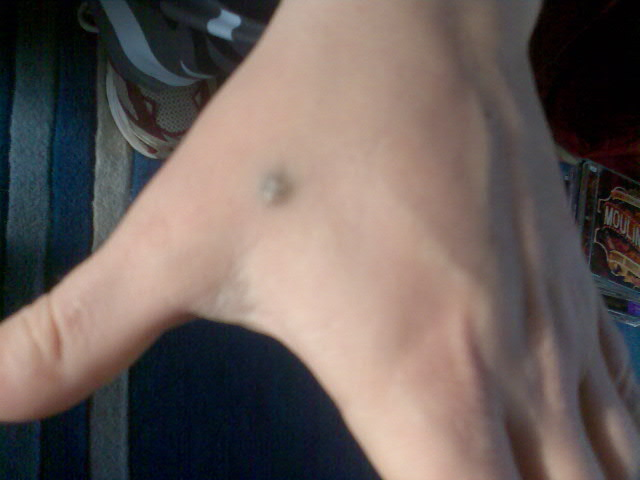

Correct Translation: Das Leberfleck muss entfernt werden.
Incorrect Translation: Der Maulwurf muss entfernt werden.


In [45]:
sample = ds[0]

print(f"Source: {sample['source']}")
display(sample["image"])
print(f"Correct Translation: {sample['correct_translation']}")
print(f"Incorrect Translation: {sample['incorrect_translation']}")

In [71]:
# run inference
prompt = f"Translate from English to German:\n{sample['source']}"
response = run_inference(sample["image"], prompt, tokenizer, model, image_processor, device, log_prompt=False)
print("-"*10)
correct_likelihood = calculate_likelihood(sample["image"], prompt, sample["correct_translation"], tokenizer, model, image_processor, device)
print("-"*10)
incorrect_likelihood = calculate_likelihood(sample["image"], prompt, sample["incorrect_translation"], tokenizer, model, image_processor, device)
print("-"*10)
print(f"Greedy Response: {response}")
print(f"Correct Likelihood: {correct_likelihood}")
print(f"Incorrect Likelihood: {incorrect_likelihood}")

tensor([     2,    106,   1645,    108,  49688,    774,   4645,    577,   5132,
        235292,    108,    651,   5265,    603,   1644,    576,   4656, 235265,
           107,    108,    106,   2516,    108], device='cuda:0')
----------
----------
----------
Greedy Response: Der Rahmen ist aus Holz.
Correct Likelihood: 1.6136294603347778
Incorrect Likelihood: 0.12315095961093903


In [66]:
# run inference on full dataset
correct_likelihoods, incorrect_likelihoods = [], []
for i, sample in enumerate(ds):
    prompt = f"Translate from English to French:\n{sample['source']}"
    #response = run_inference(sample["image"], prompt, tokenizer, model, image_processor, device)
    correct_likelihood = calculate_likelihood(sample["image"], prompt, sample["correct_translation"], tokenizer, model, image_processor, device)
    incorrect_likelihood = calculate_likelihood(sample["image"], prompt, sample["incorrect_translation"], tokenizer, model, image_processor, device)
    # print(f"Greedy Response: {response}")
    correct_likelihoods.append(correct_likelihood)
    incorrect_likelihoods.append(incorrect_likelihood)
    print(f"{i}/{len(ds)}")

0/300
1/300
2/300
3/300
4/300
5/300
6/300
7/300
8/300
9/300
10/300
11/300
12/300
13/300
14/300
15/300
16/300
17/300
18/300
19/300
20/300
21/300
22/300
23/300
24/300
25/300
26/300
27/300
28/300
29/300
30/300
31/300
32/300
33/300
34/300
35/300
36/300
37/300
38/300
39/300
40/300
41/300
42/300
43/300
44/300
45/300
46/300
47/300
48/300
49/300
50/300
51/300
52/300
53/300
54/300
55/300
56/300
57/300
58/300
59/300
60/300
61/300
62/300
63/300
64/300
65/300
66/300
67/300
68/300
69/300
70/300
71/300
72/300
73/300
74/300
75/300
76/300
77/300
78/300
79/300
80/300
81/300
82/300
83/300
84/300
85/300
86/300
87/300
88/300
89/300
90/300
91/300
92/300
93/300
94/300
95/300
96/300
97/300
98/300
99/300
100/300
101/300
102/300
103/300
104/300
105/300
106/300
107/300
108/300
109/300
110/300
111/300
112/300
113/300
114/300
115/300
116/300
117/300
118/300
119/300
120/300
121/300
122/300
123/300
124/300
125/300
126/300
127/300
128/300
129/300
130/300
131/300
132/300
133/300
134/300
135/300
136/300
137/300
138/30

In [ ]:
# print accuracy
correct_counts = [1 if correct_likelihood < incorrect_likelihood else 0 for correct_likelihood, incorrect_likelihood in zip(correct_likelihoods, incorrect_likelihoods)]
accuracy = sum(correct_counts) / len(correct_counts)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7066666666666667


# **Transformers** Port

In [3]:
import torch
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration

device = "cuda"
#model_name = "/mnt/scratch-artemis/patrick/lnext-towerq-7b-hf"
#model_name = "/mnt/scratch-artemis/patrick/lnext-tower4-sugarloaf-hf/"
model_name = "/mnt/scratch-artemis/gviveiros/TowerVision/towerp_2b_instruct/"
processor = LlavaNextProcessor.from_pretrained(model_name)
model = LlavaNextForConditionalGeneration.from_pretrained(
    model_name, 
    device_map=device,
    torch_dtype=torch.bfloat16
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


In [4]:
processor.chat_template, processor.tokenizer.add_bos_token

("{{ bos_token }}{% for message in messages %}{% if message['role'] == 'assistant' %}{% set role = 'model' %}{% else %}{% set role = message['role'] %}{% endif %}<start_of_turn>{{ role }}\n{{ message['content'] | trim }}<end_of_turn>\n{% endfor %}{% if add_generation_prompt %}<start_of_turn>model\n{% endif %}",
 True)

In [14]:
# HARDCODED REMOVE
#processor.chat_template = """{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% for message in messages %}{{ '<|im_start|>' + message['role'] + '\n' }}{% if message['content'] is string %}{{ message['content'] }}{% else %}{# Render all images first #}{% for content in message['content'] | selectattr('type', 'equalto', 'image') %}{{ '<image>\n' }}{% endfor %}{# Render all text next #}{% for content in message['content'] | selectattr('type', 'equalto', 'text') %}{{ content['text'] }}{% endfor %}{% endif %}{{ '<|im_end|>' + '\n' }}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"""
#processor.tokenizer.add_bos_token = False

In [15]:
# HARCODED REMOVE
#model.generation_config.bos_token_id = 3
#model.generation_config.eos_token_id = 4
#processor.tokenizer.bos_token = "<|im_start|>"
#processor.tokenizer.eos_token = "<|im_end|>"

In [5]:
import datasets

# load dataset
ds = datasets.load_dataset("Unbabel/commute_multimodal_mt", split="de")

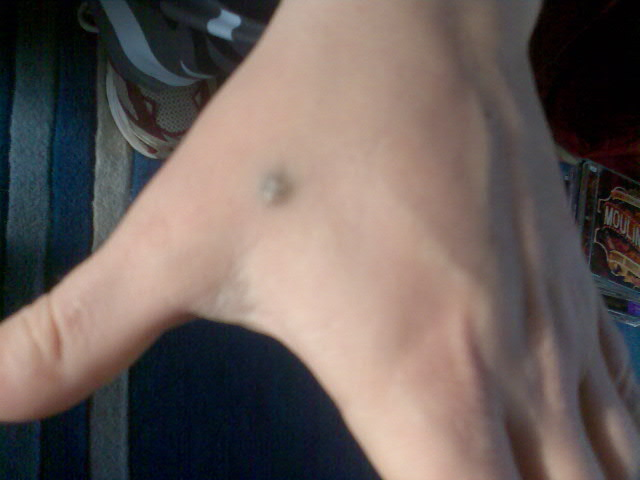

Query: Translate from English to Portuguese:
We'll have to get rid of that mole.
Prompt being used:  <start_of_turn>system
You are a helpful assistant.<end_of_turn>
<start_of_turn>user
<image>
Translate from English to Portuguese:
We'll have to get rid of that mole.<end_of_turn>
<start_of_turn>model

Response: <bos><start_of_turn>system
You are a helpful assistant.<end_of_turn>
<start_of_turn>user
<image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><ima

In [7]:
from PIL import Image
import requests

# url = "https://eatingarounditaly.com/wp-content/uploads/2023/03/pizzeria-napoli-2048x1536.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
# display(image)
sample = ds[0]
image = sample["image"]
display(image)

#template = """{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"""
def prepare_prompt(query):
    conversation = [
        {
            "role": "system", 
            "content": "You are a helpful assistant."
        },
        {
            "role": "user", 
            "content": f"<image>\n{query}"
        }
    ]
    # processor.tokenizer.add_bos_token = False
    #if processor.tokenizer.chat_template is None:
    #    processor.tokenizer.chat_template = template
    prompt = processor.tokenizer.apply_chat_template(
        conversation, 
        tokenize=False,
        add_generation_prompt=True
    )
    # remove <bos> from prompt
    prompt = prompt.replace("<bos>", "")
    
    return prompt

query = f"Translate from English to Portuguese:\n{sample['source']}"
print(f"Query: {query}")
prompt = prepare_prompt(query)
print("Prompt being used: ", prompt)
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)

outputs = model.generate(**inputs, do_sample=False, eos_token_id=processor.tokenizer.eos_token_id, max_new_tokens=64)
response = processor.decode(outputs[0], skip_special_tokens=False)
print(f"Response: {response}")

# print("-"*10)
# sample = ds[0]
# source = sample["source"]
# query = f"Translate from English to Portuguese:\n{source}"
# print(f"Query: {query}")
# prompt = prepare_prompt(query)
# inputs = processor(images=sample["image"], text=prompt, return_tensors="pt").to(device)
# outputs = model.generate(**inputs, do_sample=False, eos_token_id=processor.tokenizer.eos_token_id, max_new_tokens=64)
# response = processor.decode(outputs[0], skip_special_tokens=False)
# print(f"Response: {response}")

In [61]:
# Define Likelihood function
def calculate_likelihood(
    image, 
    prompt,
    target,
    tokenizer=tokenizer,
    model=model,
    image_processor=image_processor,
    device=device,
    conv_template="gemma2_instruct",
    log_prompt=False
):
    """
    Calculate the likelihood of a given translation for an image-text pair
    
    Args:
        image: PIL image
        source_text: Source text to translate
        target_text: Target translation to evaluate
        tokenizer, model, image_processor: Pre-loaded model components
        device: The device to run inference on
        conv_template: Conversation template to use
    
    Returns:
        tuple: (loss value, boolean indicating if greedy prediction matches target exactly)
    """
    # Process image
    image_size = [image.size[0], image.size[1]]
    processed_image = image_processor(image, return_tensors="pt")["pixel_values"]
    
    if torch.cuda.is_available():
        processed_image = processed_image.to(dtype=torch.bfloat16, device=device)
    
    # Prepare prompt
    if DEFAULT_IMAGE_TOKEN not in prompt:
        #print(f"Adding {DEFAULT_IMAGE_TOKEN} to prompt")
        prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt
    
    # Prepare conversation
    if "llama_3" in conv_template:
        conv = copy.deepcopy(conv_templates[conv_template])
    else:
        conv = conv_templates[conv_template].copy()
    
    # First create context-only conversation (up to model's turn)
    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], None)
    context_prompt = conv.get_prompt()

    if log_prompt:
        print(context_prompt)
    
    # Tokenize context
    context_ids = tokenizer_image_token(context_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").to(device)
    
    # Now create full conversation with target answer
    conv.messages[-1][1] = target  # Set the model's response to the target text
    full_prompt = conv.get_prompt()
    if log_prompt:
        print(full_prompt)
    
    # Tokenize full prompt
    input_ids = tokenizer_image_token(full_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
    
    # Create labels with -100 for context part (we don't compute loss for it)
    labels = input_ids.clone()
    labels[0, :context_ids.shape[0]] = -100
    
    # Calculate loss
    with torch.inference_mode():
        outputs = model(
            input_ids=input_ids, 
            labels=labels, 
            images=processed_image, 
            use_cache=True, 
            image_sizes=[image_size]
        )
    
    loss = outputs["loss"]
    
    # Check if greedy prediction matches target
    logits = outputs["logits"]
    greedy_tokens = logits.argmax(dim=-1)
    # print(logits.shape)
    target_tokens = input_ids[:, context_ids.shape[0]:]  # Skip the context tokens
    greedy_tokens = greedy_tokens[:, context_ids.shape[0]:input_ids.shape[1]]  # Use only relevant predictions
    max_equal = (greedy_tokens == target_tokens).all()
    
    return float(loss.item())

In [70]:
device

'cuda'

In [73]:
# check if is on cuda
processor.image_processor(sample["image"], return_tensors="pt")["pixel_values"].to(device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [75]:
pixels = processor.image_processor(sample["image"], return_tensors="pt")["pixel_values"]
print(pixels.shape, pixels.min(), pixels.max(), pixels.dtype)

torch.Size([1, 5, 3, 384, 384]) tensor(-1.) tensor(0.8196) torch.float32


In [62]:
# run inference on full dataset
correct_likelihoods, incorrect_likelihoods = [], []
for i, sample in enumerate(ds):
    prompt = f"Translate from English to French:\n{sample['source']}"
    #response = run_inference(sample["image"], prompt, tokenizer, model, image_processor, device)
    correct_likelihood = calculate_likelihood(sample["image"], prompt, sample["correct_translation"], processor.tokenizer, model, processor.image_processor, device)
    incorrect_likelihood = calculate_likelihood(sample["image"], prompt, sample["incorrect_translation"], processor.tokenizer, model, processor.image_processor, device)
    # print(f"Greedy Response: {response}")
    correct_likelihoods.append(correct_likelihood)
    incorrect_likelihoods.append(incorrect_likelihood)
    print(f"{i}/{len(ds)}")
# print accuracy
correct_counts = [1 if correct_likelihood < incorrect_likelihood else 0 for correct_likelihood, incorrect_likelihood in zip(correct_likelihoods, incorrect_likelihoods)]
accuracy = sum(correct_counts) / len(correct_counts)
print(f"Accuracy: {accuracy}")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [35]:
print(response.count("<image>"))
inputs["pixel_values"].shape

2929


torch.Size([1, 7, 3, 384, 384])

In [4]:
27*27

729

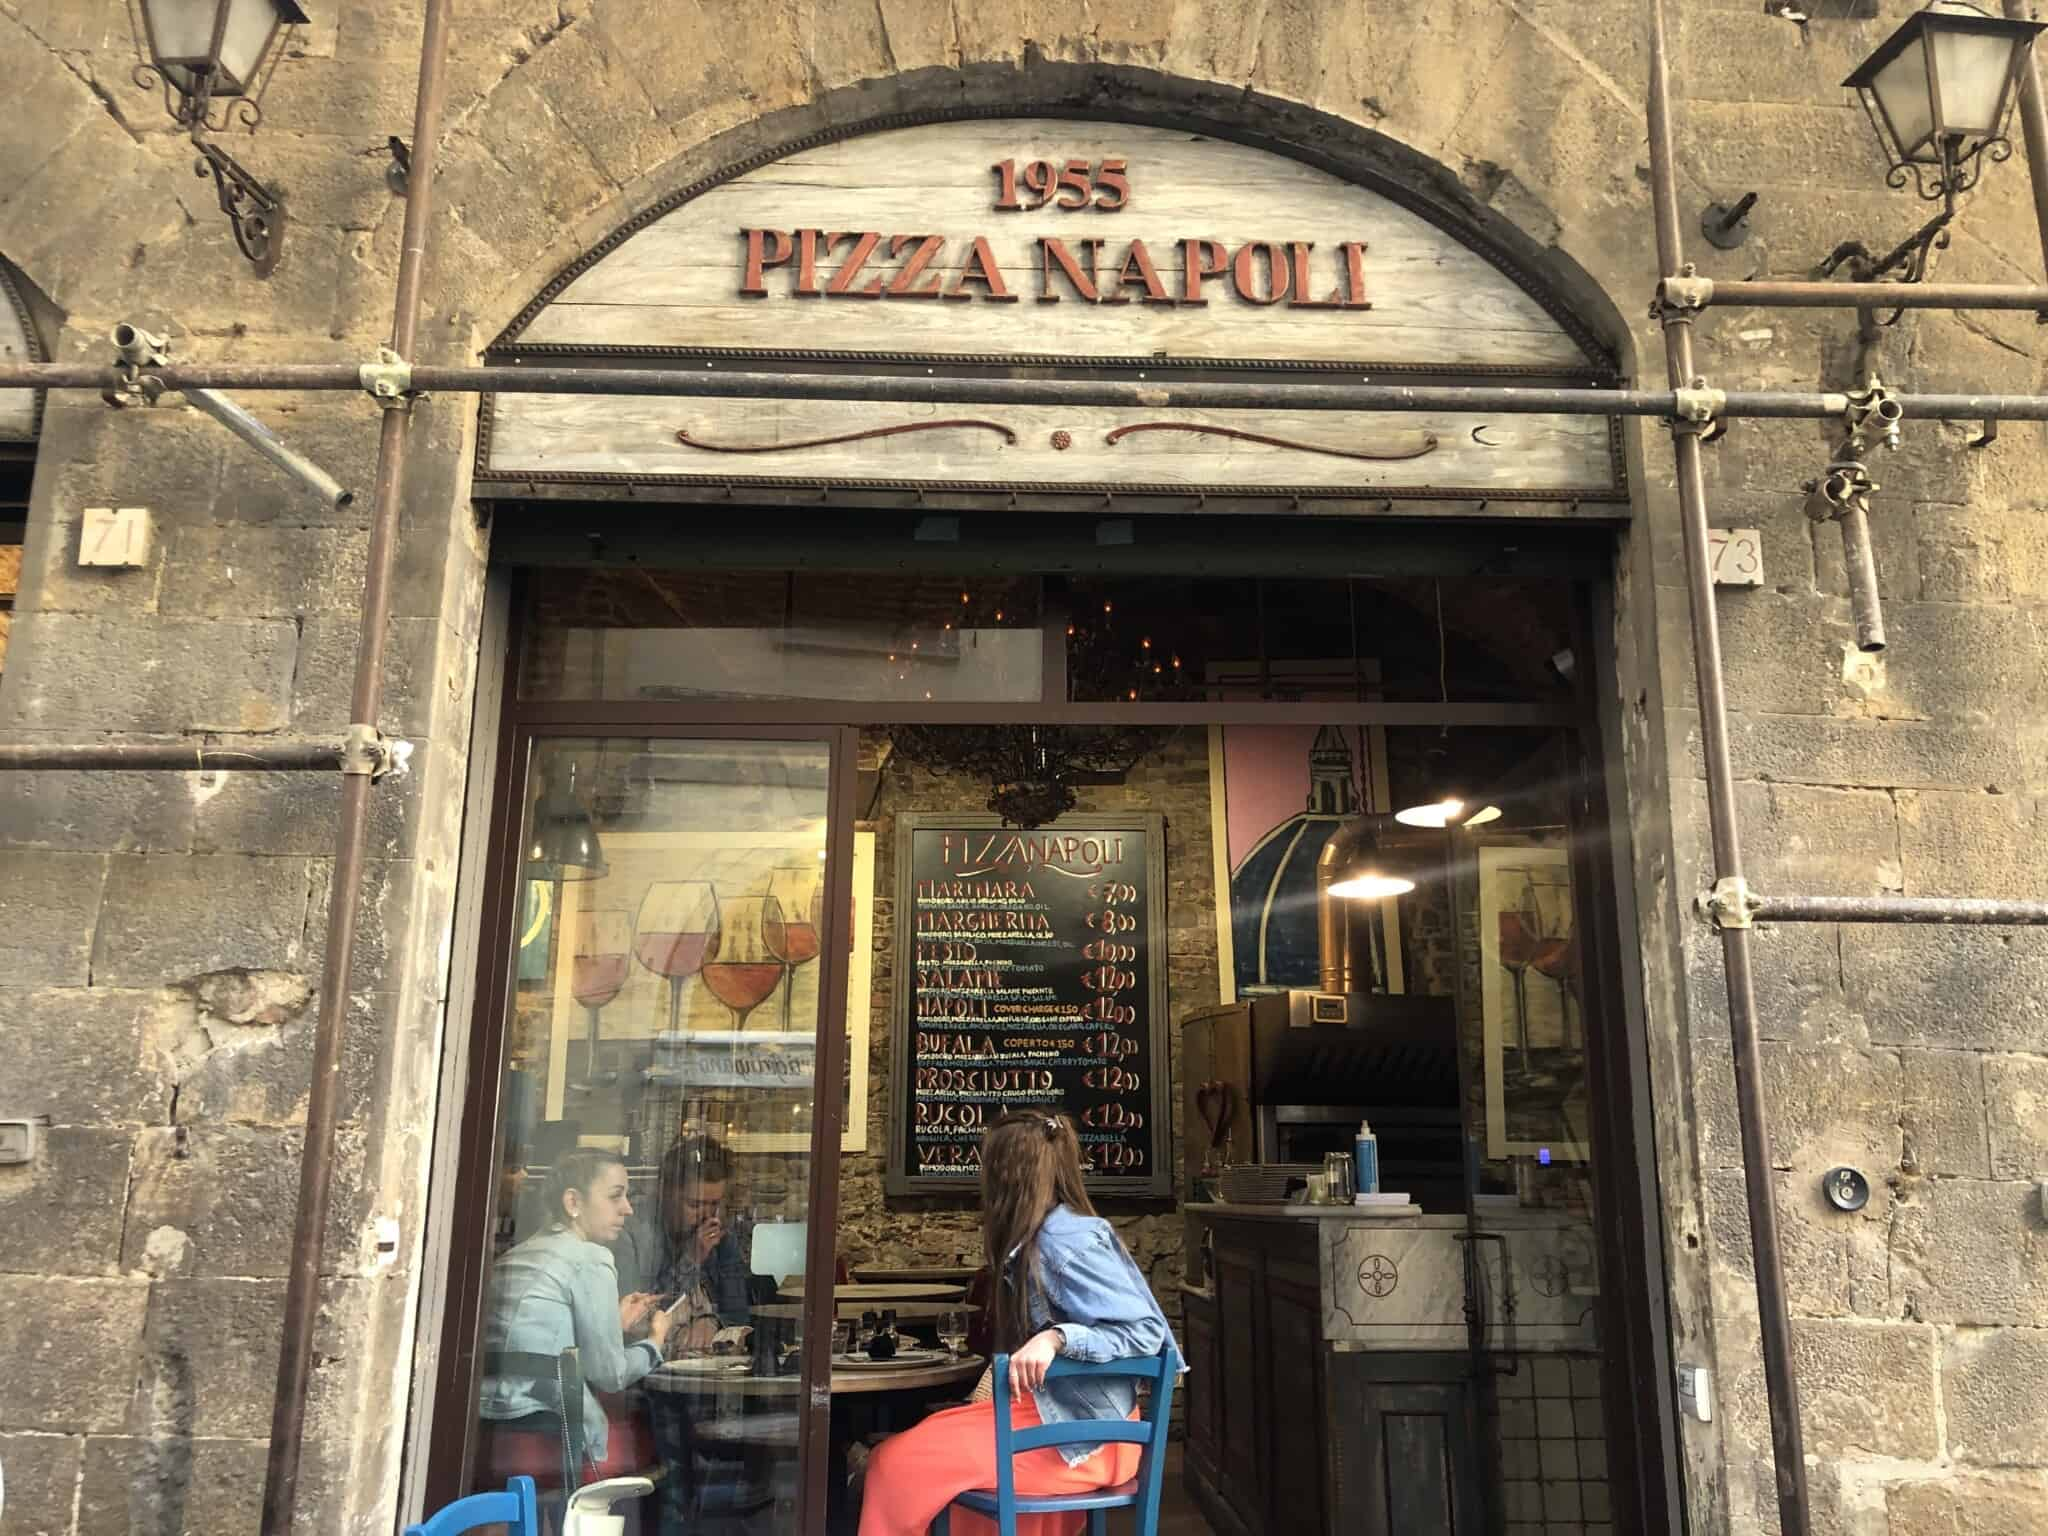

Query: How much would I pay for a Margherita?


ValueError: Image features and image tokens do not match: tokens: 0, features 4725

In [31]:
from PIL import Image
import requests

url = "https://eatingarounditaly.com/wp-content/uploads/2023/03/pizzeria-napoli-2048x1536.jpg"
image = Image.open(requests.get(url, stream=True).raw)
display(image)

#template = """{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"""
def prepare_prompt(query):
    conversation = [
        {
            "role": "system", 
            "content": "You are a helpful assistant."
        },
        {
            "role": "user", 
            "content": [
                {"type": "image"},
                {"type": "text", "text": query}
            ]
        }
    ]
    prompt = processor.apply_chat_template(
        conversation, 
        add_generation_prompt=True
    )
    # remove <bos> from prompt
    prompt = prompt.replace("<bos>", "")
    return prompt

query = f"How much would I pay for a Margherita?"
print(f"Query: {query}")
prompt = prepare_prompt(query)
#print(prompt)
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)

outputs = model.generate(**inputs, do_sample=False, eos_token_id=processor.tokenizer.eos_token_id, max_new_tokens=64)
response = processor.decode(outputs[0], skip_special_tokens=False)
print(f"Response: {response}")

source = "This building is amazing." # sample["source"] 
query = f"Translate from English to Portuguese:\n{source}"
print(f"Query: {query}")
prompt = prepare_prompt(query)
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)
outputs = model.generate(**inputs, do_sample=False, eos_token_id=processor.tokenizer.eos_token_id, max_new_tokens=64)
response = processor.decode(outputs[0], skip_special_tokens=False)
print(f"Response: {response}")

In [32]:
print(response.count("<image>"))

2929


# **VLLM** Port

In [2]:
from transformers import LlavaNextProcessor
import vllm

#model_name = "/mnt/scratch-artemis/patrick/lnext-towerq-7b-hf"
#model_name = "Unbabel/lnext-towerq-7b-hf"
#model_name = "/mnt/scratch-artemis/patrick/lnext-tower4-sugarloaf-hf/"
#model_name = "Unbabel/TowerQ-7B-Vision"
#model_name = "Unbabel/EuroVLM-9B-step9786"
model_name = "utter-project/EuroVLM-9B-Preview"
processor = LlavaNextProcessor.from_pretrained(model_name)
model = vllm.LLM(model=model_name)

/mnt/home/patrick/.conda/envs/lnext-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 06-09 11:02:12 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 06-09 11:02:16 [__init__.py:239] Automatically detected platform cuda.


2025-06-09 11:02:26,040	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


INFO 06-09 11:03:12 [config.py:717] This model supports multiple tasks: {'generate', 'embed', 'reward', 'classify', 'score'}. Defaulting to 'generate'.
INFO 06-09 11:03:12 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 06-09 11:03:17 [core.py:58] Initializing a V1 LLM engine (v0.8.5.post1) with config: model='utter-project/EuroVLM-9B-Preview', speculative_config=None, tokenizer='utter-project/EuroVLM-9B-Preview', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_t

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:06<00:19,  6.35s/it]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:12<00:12,  6.30s/it]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:19<00:06,  6.50s/it]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:26<00:00,  6.71s/it]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:26<00:00,  6.60s/it]



INFO 06-09 11:04:37 [loader.py:458] Loading weights took 26.60 seconds
INFO 06-09 11:04:38 [gpu_model_runner.py:1347] Model loading took 17.8473 GiB and 66.690519 seconds
INFO 06-09 11:04:38 [gpu_model_runner.py:1620] Encoder cache will be initialized with a budget of 8192 tokens, and profiled with 2 image items of the maximum feature size.
INFO 06-09 11:05:04 [backends.py:420] Using cache directory: /mnt/home/patrick/.cache/vllm/torch_compile_cache/30dd29705c/rank_0_0 for vLLM's torch.compile
INFO 06-09 11:05:04 [backends.py:430] Dynamo bytecode transform time: 25.25 s
INFO 06-09 11:05:14 [backends.py:136] Cache the graph of shape None for later use
INFO 06-09 11:05:53 [backends.py:148] Compiling a graph for general shape takes 48.18 s
INFO 06-09 11:06:10 [monitor.py:33] torch.compile takes 73.44 s in total
INFO 06-09 11:06:11 [kv_cache_utils.py:634] GPU KV cache size: 145,040 tokens
INFO 06-09 11:06:11 [kv_cache_utils.py:637] Maximum concurrency for 32,768 tokens per request: 4.43x
I

In [4]:
import datasets

# load dataset
ds = datasets.load_dataset("Unbabel/commute_multimodal_mt", split="de")

[2025-06-09 11:10:47] INFO config.py:58: PyTorch version 2.6.0 available.


In [5]:
sample = ds[0]

# Function to prepare a prompt for VLLM
def prepare_prompt(query):
    conversation = [
        {
            "role": "system", 
            "content": "You are a helpful assistant."
        },
        {
            "role": "user", 
            "content": f"<image>\n{query}"
        }
    ]
    # Apply chat template without tokenization
    prompt = processor.apply_chat_template(
        conversation, 
        add_generation_prompt=True
    )
    return prompt

# Example of single prompt inference with VLLM
print("Running VLLM inference...")
query = "What's in this image? Respond in one sentence."
print(f"Query: {query}")
prompt = prepare_prompt(query)
sampling_params = vllm.SamplingParams(
    max_tokens=128,
    temperature=0.0,
)
vllm_outputs = model.generate(
    {
        "prompt": prompt,
        "multi_modal_data": {"image": sample["image"]},
    },
    sampling_params=sampling_params,
)

# Print the generated response
for output in vllm_outputs:
    vllm_response = output.outputs[0].text
    print(f"VLLM Response: {vllm_response}")


Running VLLM inference...
Query: What's in this image? Respond in one sentence.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it, est. speed input: 2252.73 toks/s, output: 17.47 toks/s]

VLLM Response: The image shows a close-up of a person's hand with a small bump on the palm.


In [4]:
from PIL import Image
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import requests
    
model_id = "utter-project/EuroVLM-9B-Preview"
processor = LlavaNextProcessor.from_pretrained(model_id)
model = LlavaNextForConditionalGeneration.from_pretrained(model_id)
model.to("cuda")

# Load an image
#image = Image.open("")
image_url = "https://eatingarounditaly.com/wp-content/uploads/2023/03/pizzeria-napoli-2048x1536.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
    
messages = [
    {
        "role": "system",
        "content": "You are EuroVLM --- a multimodal AI assistant specialized in European languages that provides safe, educational and helpful answers about images and text.",
    },
    {
        "role": "user", 
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What do you see in this image? Please describe it in Portuguese, in one sentence only!"}
        ]
    },
]

prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=1024)
print(processor.decode(outputs[0], skip_special_tokens=True))

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]
Setting `pad_token_id` to `eos_token_id`:4 for open-end generation.


system
You are EuroVLM --- a multimodal AI assistant specialized in European languages that provides safe, educational and helpful answers about images and text. 
 user
 
What do you see in this image? Please describe it in Portuguese, in one sentence only! 
 assistant
A imagem mostra a fachada de um restaurante chamado "Pizza Napoli", fundado em 1955. A fachada é de pedra e tem uma placa de madeira com o nome do restaurante e o ano de fundação. Há uma porta de vidro que dá acesso ao interior do restaurante, onde se pode ver um menu escrito à mão e alguns clientes sentados à mesa. A imagem foi tirada em Nápoles, Itália.


In [4]:
from PIL import Image
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import requests
    
model_id = "utter-project/EuroVLM-1.7B-Preview"
processor = LlavaNextProcessor.from_pretrained(model_id)
model = LlavaNextForConditionalGeneration.from_pretrained(model_id)

# Load an image
#image = Image.open("/path/to/image.jpg")
image_url = "https://eatingarounditaly.com/wp-content/uploads/2023/03/pizzeria-napoli-2048x1536.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
    
messages = [
    {
        "role": "system",
        "content": "You are EuroVLM --- a multimodal AI assistant specialized in European languages that provides safe, educational and helpful answers about images and text.",
    },
    {
        "role": "user", 
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What do you see in this image? Please describe it in Portuguese."}
        ]
    },
]

prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(images=image, text=prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_new_tokens=1024)
print(processor.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:4 for open-end generation.


system
You are EuroVLM --- a multimodal AI assistant specialized in European languages that provides safe, educational and helpful answers about images and text. 
 user
 
What do you see in this image? Please describe it in Portuguese. 
 assistant
A imagem mostra a fachada de um restaurante italiano chamado "1955 Pizza Napoli", localizado em Nápoles, Itália. A fachada é feita de pedra e tem um letreiro em madeira com a inscrição "1955 PIZZA NAPOLI" em letras douradas. O letreiro está acima de uma porta de vidro que dá acesso ao interior do restaurante. 

Na entrada, há uma mulher sentada em uma cadeira azul, observando o menu do restaurante. Ela está vestida com uma camisa azul e uma saia laranja. Atrás dela, há uma mesa com duas pessoas sentadas, uma delas parece estar falando ao telefone. 

O interior do restaurante é simples e acolhedor, com uma decoração que remete à tradição italiana. Há uma placa de menu em uma parede atrás da mesa, com os preços das pizzas. 

A imagem captura a 

In [ ]:
from vllm import LLM, SamplingParams

# Initialize the model
model_id = "utter-project/EuroVLM-9B-Preview"
llm = LLM(model=model_id)

# Set up sampling parameters
sampling_params = SamplingParams(temperature=0.7, max_tokens=1024)

# Image and prompt
image_url = "/url/of/image.jpg"

messages = [
    {
        "role": "system",
        "content": "You are EuroVLM --- a multimodal AI assistant specialized in European languages that provides safe, educational and helpful answers about images and text.",
    },
    {
        "role": "user", 
        "content": [
            {"type": "image_url", "image_url": {"url": image_url}},
            {"type": "text", "text": "What do you see in this image? Please describe it in Portuguese in one sentence."}
        ]
    },
]

# Generate response
outputs = llm.chat(messages, sampling_params=sampling_params)
print(outputs[0].outputs[0].text)

/mnt/home/patrick/.conda/envs/lnext-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 06-09 11:49:06 [__init__.py:239] Automatically detected platform cuda.


2025-06-09 11:49:16,234	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 06-09 11:49:55 [config.py:717] This model supports multiple tasks: {'generate', 'score', 'embed', 'classify', 'reward'}. Defaulting to 'generate'.
INFO 06-09 11:49:55 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 06-09 11:50:01 [core.py:58] Initializing a V1 LLM engine (v0.8.5.post1) with config: model='utter-project/EuroVLM-9B-Preview', speculative_config=None, tokenizer='utter-project/EuroVLM-9B-Preview', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_t

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


WARNING 06-09 11:50:16 [topk_topp_sampler.py:69] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.
INFO 06-09 11:50:16 [gpu_model_runner.py:1329] Starting to load model utter-project/EuroVLM-9B-Preview...
INFO 06-09 11:50:16 [config.py:3614] cudagraph sizes specified by model runner [1, 2, 4, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336, 344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440, 448, 456, 464, 472, 480, 488, 496, 504, 512] is overridden by config [512, 384, 256, 128, 4, 2, 1, 392, 264, 136, 8, 400, 272, 144, 16, 408, 280, 152, 24, 416, 288, 160, 32, 424, 296, 168, 40, 432, 304, 176, 48, 440, 312, 184, 56, 448, 320, 192, 64, 456, 328, 200, 72, 464, 336, 208, 80, 472, 344, 216, 88, 120, 480, 352, 248, 224, 96,

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.21s/it]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:02<00:02,  1.27s/it]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:04<00:01,  1.41s/it]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:05<00:00,  1.47s/it]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:05<00:00,  1.41s/it]



INFO 06-09 11:50:24 [loader.py:458] Loading weights took 6.01 seconds
INFO 06-09 11:50:24 [gpu_model_runner.py:1347] Model loading took 17.8473 GiB and 7.647160 seconds
INFO 06-09 11:50:24 [gpu_model_runner.py:1620] Encoder cache will be initialized with a budget of 8192 tokens, and profiled with 2 image items of the maximum feature size.
INFO 06-09 11:50:51 [backends.py:420] Using cache directory: /mnt/home/patrick/.cache/vllm/torch_compile_cache/30dd29705c/rank_0_0 for vLLM's torch.compile
INFO 06-09 11:50:51 [backends.py:430] Dynamo bytecode transform time: 25.13 s
INFO 06-09 11:51:01 [backends.py:118] Directly load the compiled graph(s) for shape None from the cache, took 10.031 s
INFO 06-09 11:51:03 [monitor.py:33] torch.compile takes 25.13 s in total
INFO 06-09 11:51:05 [kv_cache_utils.py:634] GPU KV cache size: 145,040 tokens
INFO 06-09 11:51:05 [kv_cache_utils.py:637] Maximum concurrency for 32,768 tokens per request: 4.43x
INFO 06-09 11:51:28 [gpu_model_runner.py:1686] Graph c

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


INFO 06-09 11:51:33 [chat_utils.py:397] Detected the chat template content format to be 'openai'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.18s/it, est. speed input: 924.98 toks/s, output: 27.24 toks/s]

A imagem mostra a fachada de uma pizzaria chamada "Pizza Napoli", fundada em 1955. A pizzaria está localizada em um prédio antigo, com uma fachada de tijolos e uma porta de vidro. Há uma placa acima da entrada, com o nome da pizzaria em letras douradas. Há também um menu escrito à mão, que lista os diferentes tipos de pizza que são oferecidos. No interior da pizzaria, podemos ver uma mulher sentada em uma mesa, comendo uma pizza. Há também uma pessoa sentada em uma mesa, usando um computador. A imagem é uma representação da cultura italiana, com uma pizzaria tradicional e um menu escrito à mão.
